# <a id='toc1_'></a>[T23 State Space Control - Part 0](#toc0_)

**Table of contents**<a id='toc0_'></a>    
- [T23 State Space Control - Part 0](#toc1_)    
  - [State Space Control](#toc1_1_)    
  - [FSFB Place](#toc1_2_)    
    - [Compute the Bessel Pole Locations](#toc1_2_1_)    
    - [Example using Bessel Pole Locations](#toc1_2_2_)    
    - [ITAE Optimize](#toc1_2_3_)    
    - [ITAE step response](#toc1_2_4_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

In [ ]:
import requests as req, os

URL = "https://raw.githubusercontent.com/mit-acl/16_06_Class/main/"
File = ["basic_material.py","control_materials.py"]

if not os.path.isfile(File[0]):
    print('Basic files not` found - downloading it')
    for dfile in File:
        if not os.path.isfile(dfile):
            print(dfile)
            res = req.get(URL+dfile)
            file = open(dfile, 'w')
            file.write(res.text)
            file.close()
else:
    print('Basic file found')
from basic_material import *

j = complex(0,1)

from scipy.optimize import minimize
from scipy.signal import butter,bessel
from control.matlab import tf, ss, ss2tf, step, place, rlocus, lqr, lsim, ssdata
from control_materials import *

Basic file found
Running Python: 3.12.8
Running Sympy: 1.13.3
Control Package Found
This is a library of basic functions for 16.06
This is a library of useful functions for the control systems in 16.06


## <a id='toc1_1_'></a>[State Space Control](#toc0_)

Nbar =-15.00


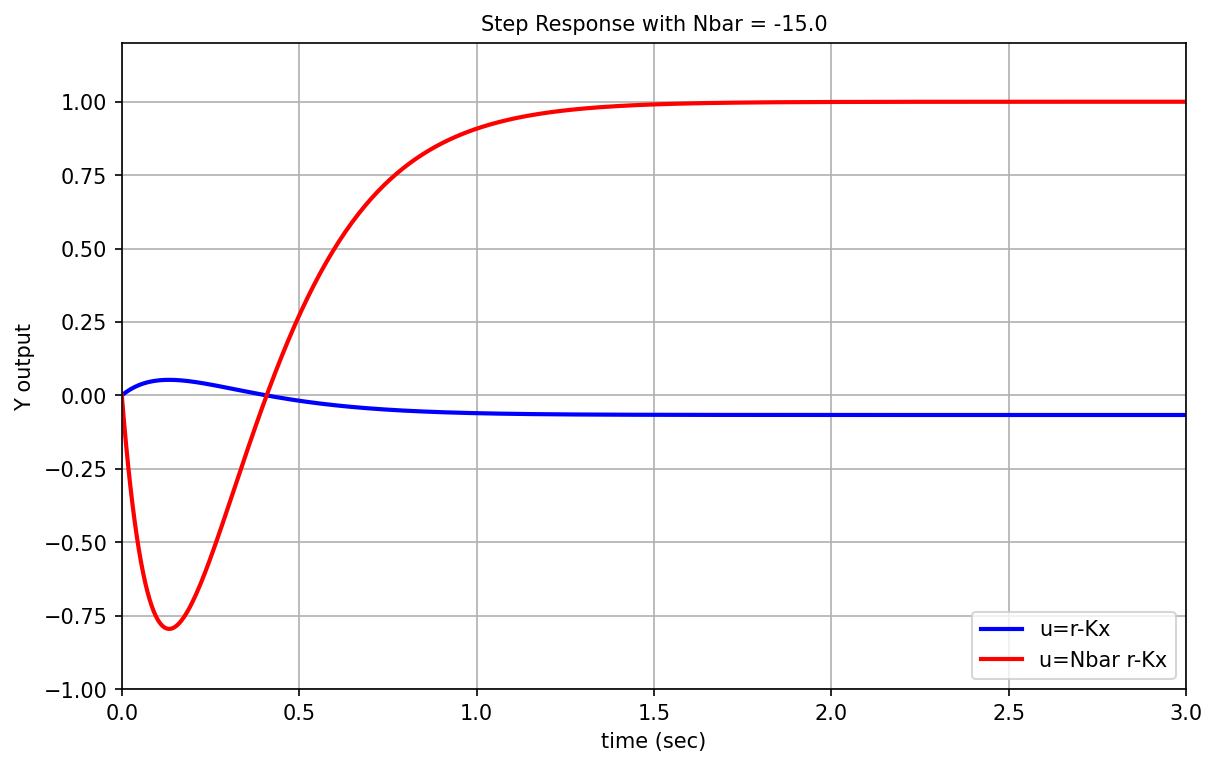

In [ ]:
# full state feedback for topic 23
# reference input issues
#
a = np.array([[1, 1],[1, 2]])
nx = np.shape(a)[0]
b = np.array([1, 0]).reshape(nx,1)
c = np.array([1, 0])
d = 0

p = np.array([-5, -6])
# gains assumed found
k = place(a, b, p)

Nbar = 1/(-c@np.linalg.inv(a-b*k)@b).item()
print(f"{Nbar =: 4.2f}")
sys1 = ss(a-b*k,b,c,d)
sys2 = ss(a-b*k,b*Nbar,c,d)

t = np.linspace(0,3,500)
y,t = step(sys1,t)
y2,t2 = step(sys2,t)

fig, ax = plt.subplots(1,figsize=(8, 5),dpi=150,constrained_layout = True)
plt.plot(t,y,'b-',label='u=r-Kx')
plt.plot(t2,y2,'r-',lw=2,label='u=Nbar r-Kx')
plt.axis([0, max(t), -1, 1.2])
plt.legend(loc=4)
plt.xlabel('time (sec)')
plt.ylabel('Y output')
plt.title('Step Response with'+f" {Nbar = : 3.1f}")
savefig("figs/Nbar.pdf", dpi=600)
plt.show()

## <a id='toc1_2_'></a>[FSFB Place](#toc0_)

In [ ]:
def compute_Nbar(G,k0):
    Nbar0 = 1.0/np.dot(-G.C,np.dot(np.linalg.inv(G.A-np.dot(G.B,k0)),G.B)).item()
    return Nbar0   

def FSFB_place(G,pr,file_name='temp',w=np.logspace(-1,2,400),Tmax=1):
    #
    k0 = place(G.A,G.B,pr)
    #
    # For state space for G_c(s)
    # find the feedforward gains
    Nbar0 = compute_Nbar(G,k0)

    sys0 = ss(G.A-G.B*k0,G.B,G.C,G.D);
    sys1 = ss(G.A-G.B*k0,G.B*Nbar0,G.C,G.D);

    if file_name == 'examp1':
        w = np.logspace(0,3,400)
    if file_name == 'examp2':
        w = np.logspace(-3,1,400)
    if file_name == 'examp3':
        w = np.logspace(-1,2,400)
    else:
        w = np.logspace(-2,2,400)
    Gf = G(w*j)
    sys0f = sys0(j*w)
    sys1f = sys1(j*w)

    t = np.arange(0,Tmax,.01)    
    y0,t0 = step(sys0,T=t)
    y1,t1 = step(sys1,T=t)

    fig, ax = plt.subplots(1,figsize=(8, 5),dpi=150,constrained_layout = True)
    ax.plot(t0,y0,'g-',label=r'$u=r-Kx$')
    ax.plot(t1,y1,'r-',label=r'$u=Nr-Kx$')
    plt.legend()
    plt.text(max(t0)/2,.8,f"{Nbar =:3.1f}", fontsize=16)
    plt.ylabel("Response")
    plt.xlabel("Time")
    savefig("figs/FSFB_pl"+file_name+"_0.pdf", dpi=600)
    plt.show()

    ymax = max(np.max(np.abs(Gf)),np.max(np.abs(sys0f)),np.max(np.abs(sys1f)))
    ymax = 10**np.ceil(np.log10(1.5*ymax))
    fig, ax = plt.subplots(2,1,figsize=(8, 5),dpi=150,constrained_layout = True)
    ax[0].loglog(w,np.abs(Gf),'b',label=r'G')
    ax[1].semilogx(w,np.unwrap(np.angle(Gf))*r2d,'b',label=r'G')
    ax[0].loglog(w,np.abs(sys0f),'g',label=r'$u=r-Kx$')
    ax[1].semilogx(w,np.unwrap(np.angle(sys0f))*r2d,'g',label=r'$u=r-Kx$')
    ax[0].loglog(w,np.abs(sys1f),'r',label=r'$u=Nr-Kx$')
    ax[1].semilogx(w,np.unwrap(np.angle(sys1f))*r2d,'r',label=r'$u=Nr-Kx$')

    ax[1].set_xlabel('Freq [r/s]')
    ax[0].set_ylabel('Mag')
    ax[1].set_ylabel('Phase (degs)')
    ax[0].grid(True, which="both", ls="-",color='0.65')
    ax[1].grid(True, which="both", ls="-",color='0.65')
    ax[0].axhline(y=1,c='k',ls='--')
    ax[1].axhline(y=-180,c='k',ls='--')
    ax[0].legend()
    ax[0].set_ylim(1e-3,ymax)
    savefig("figs/FSFB_pl"+file_name+"_1.pdf", dpi=600)
    plt.show()

    return k0

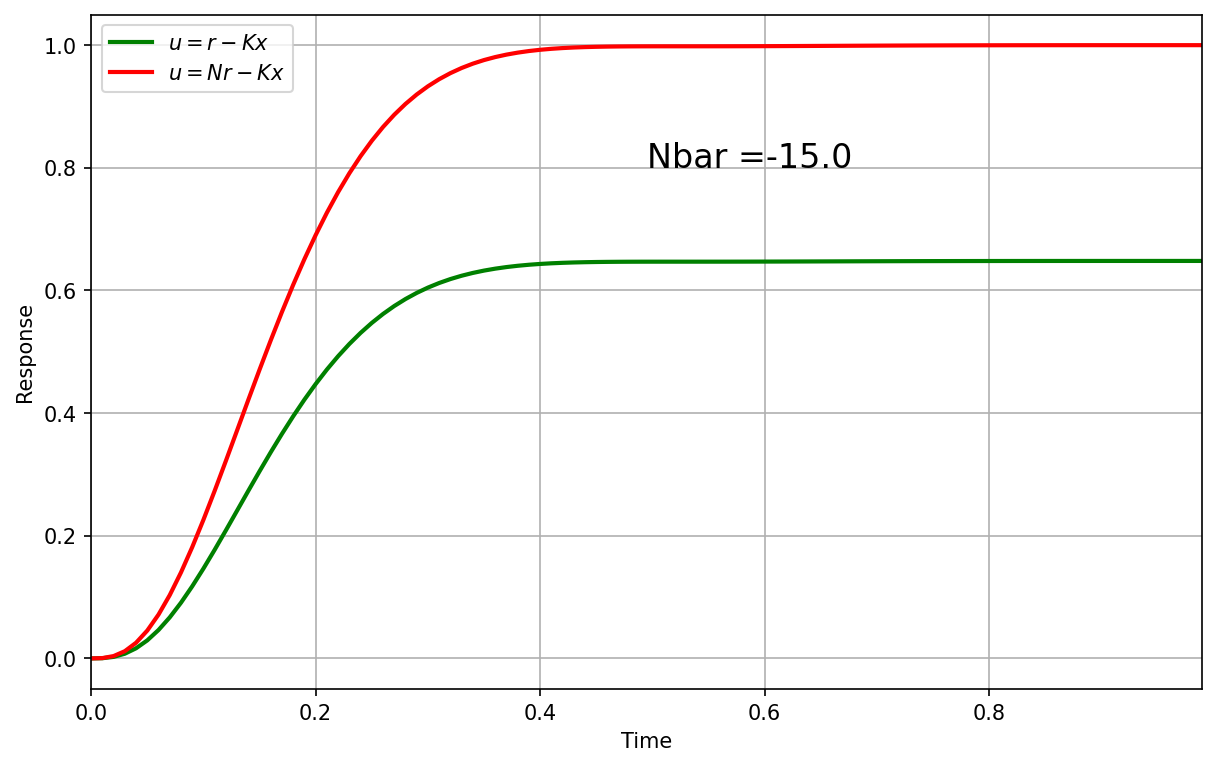

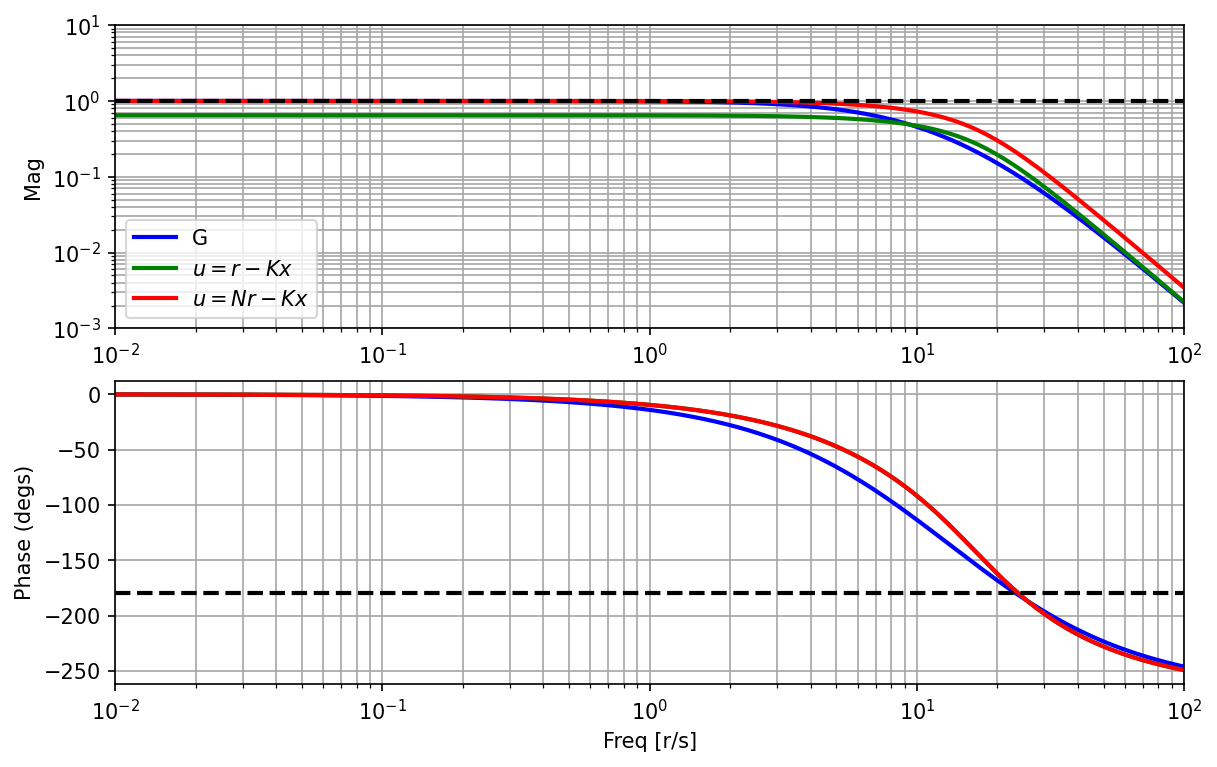

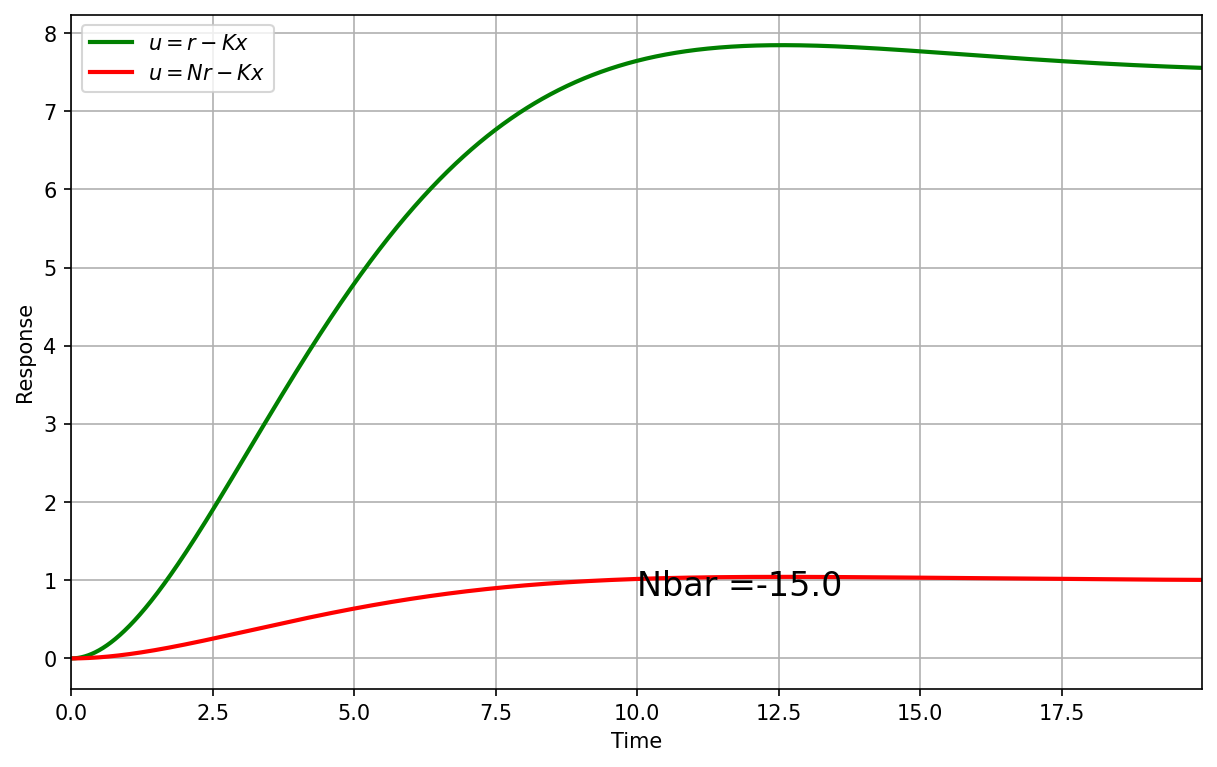

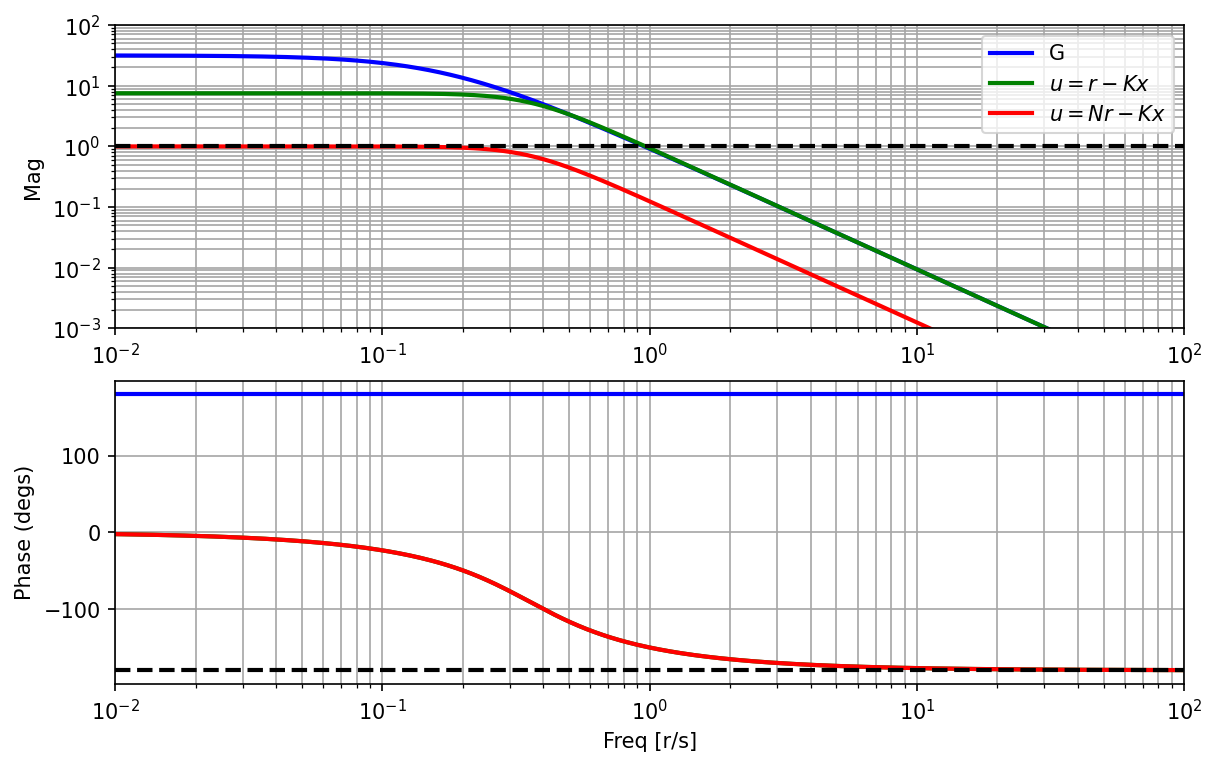

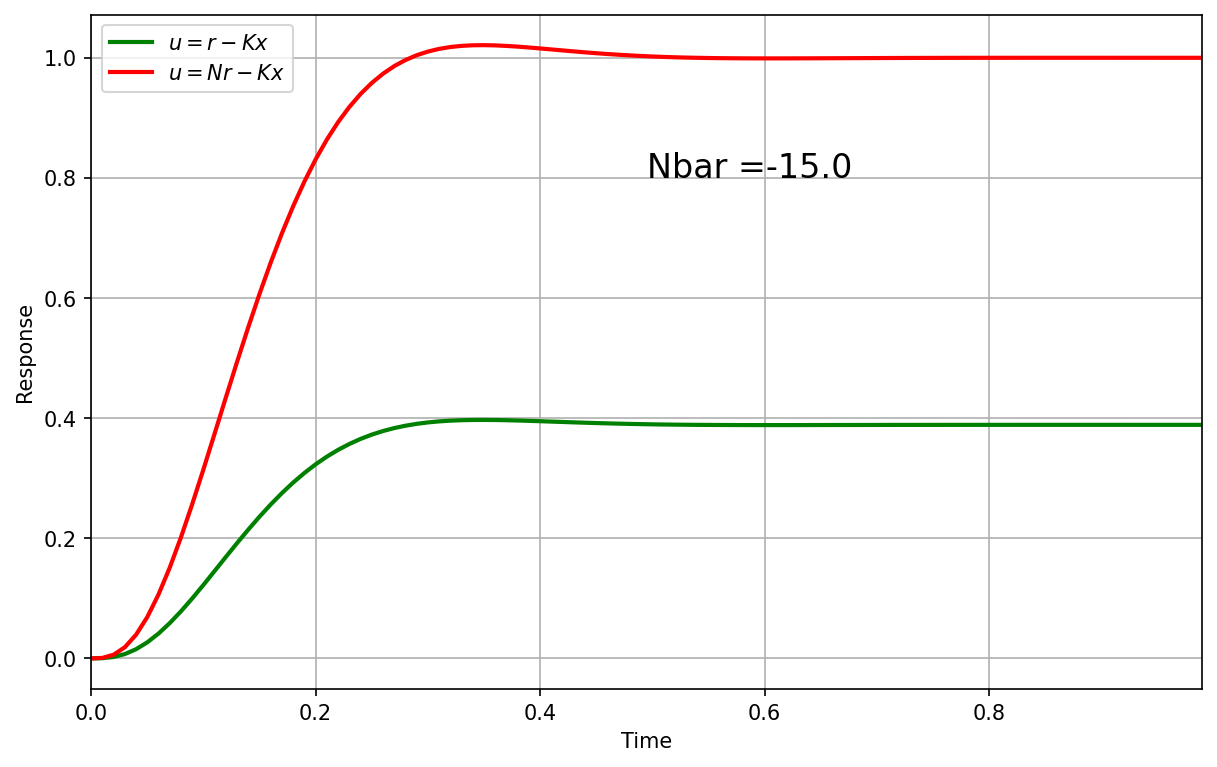

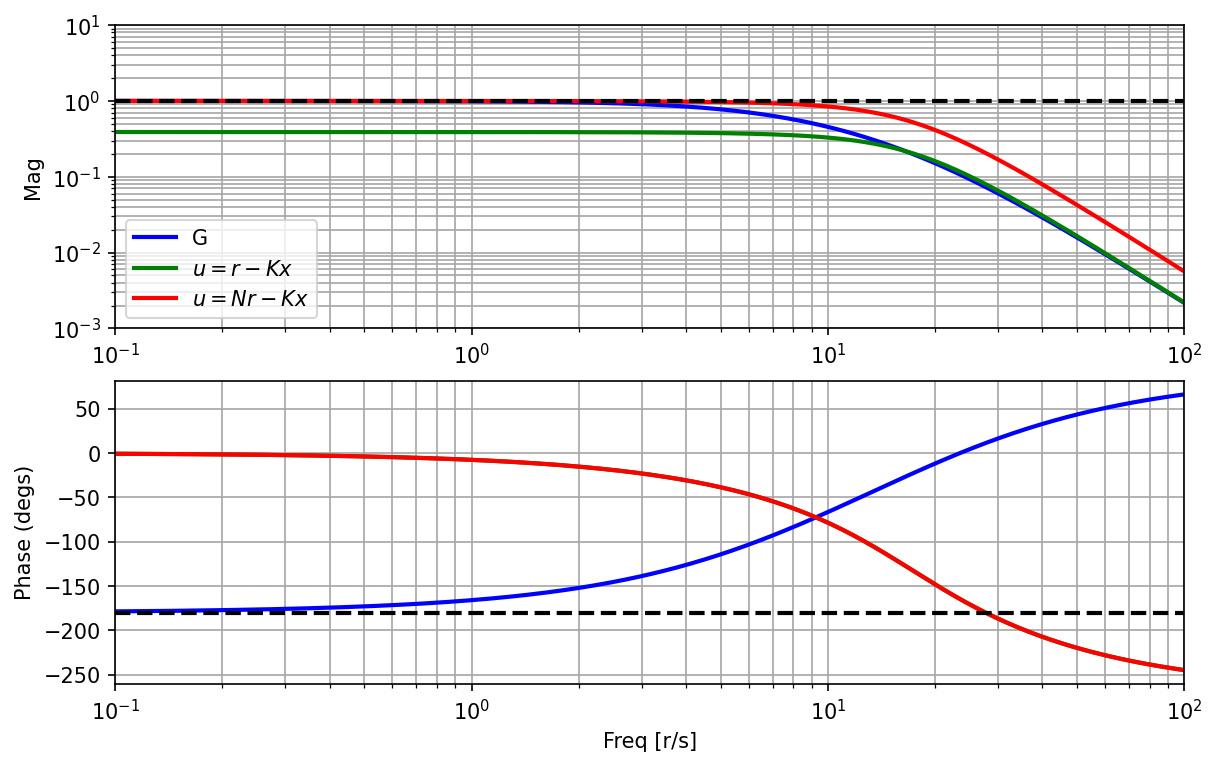

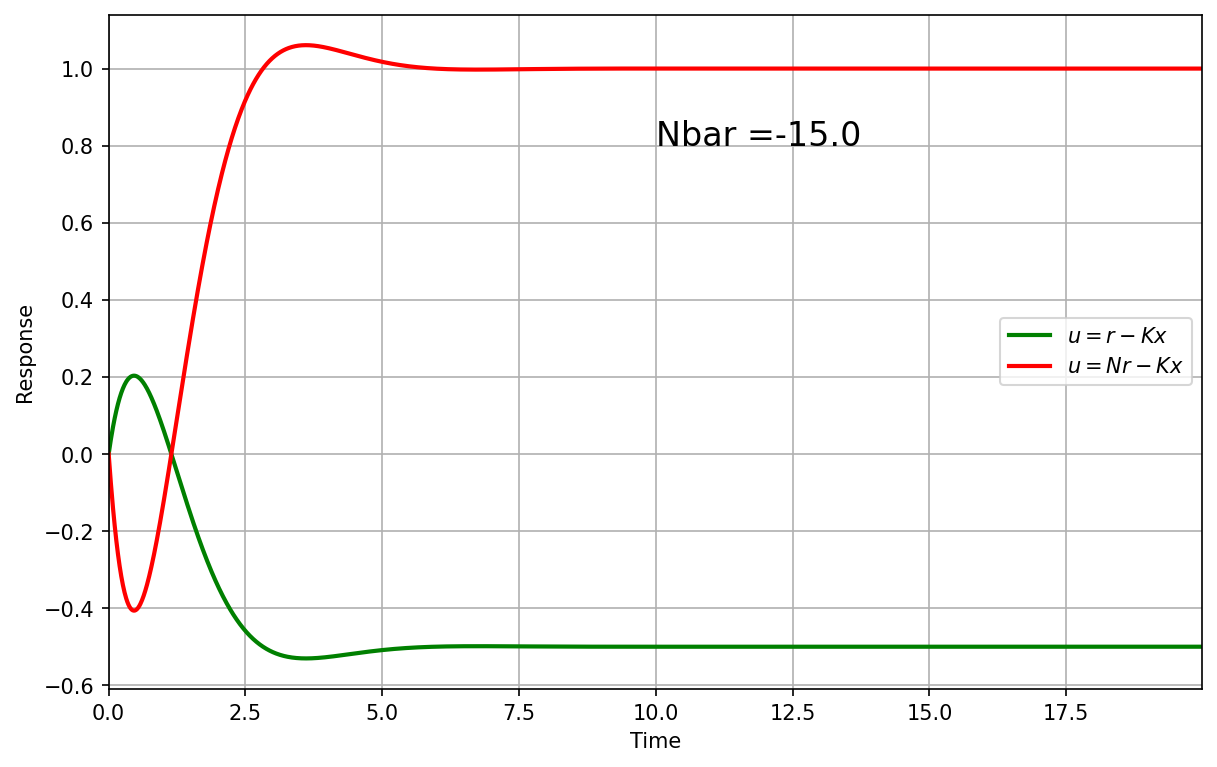

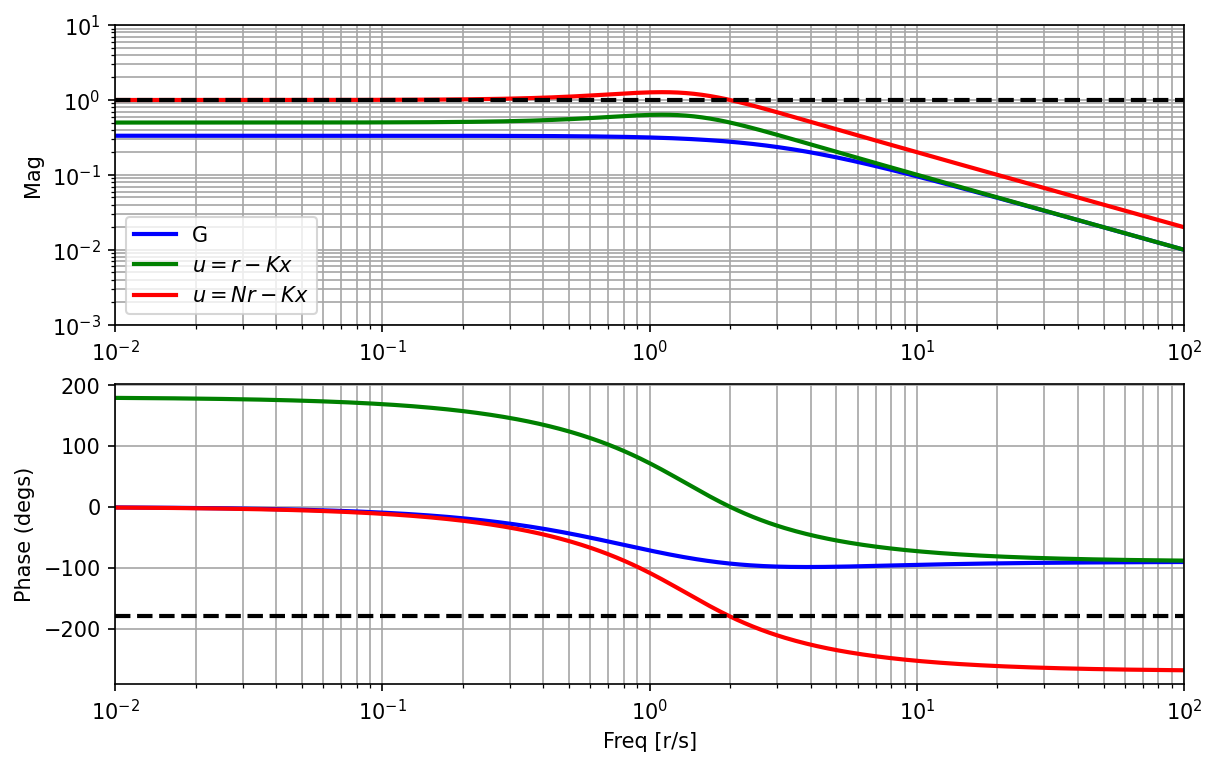

In [ ]:
G1 = ss(tf(8*14*20,np.convolve([1, 8],np.convolve([1, 14],[1, 20]))))
pr = np.array([-12,-12+12*j,-12-12*j])
file_name = 'examp1'
K1 = FSFB_place(G1,pr,file_name=file_name)

G2 = ss(tf(0.94,(1,0,-0.0297)))
pr = np.array([-0.25+0.25*j,-0.25-0.25*j])
file_name = 'examp2'
K2 = FSFB_place(G2,pr,file_name=file_name,Tmax=20)

G3 = ss(tf(8*14*20,np.convolve([1, -8],np.convolve([1, -14],[1, -20]))))
pr = np.array([-20,-12+12*j,-12-12*j])
file_name = 'examp3'
K3 = FSFB_place(G3,pr,file_name=file_name)

G4 = ss(tf((1,-1),(1,-2,-3)))
pr = np.array([-1+j,-1-j])
file_name = 'examp4'
K4 = FSFB_place(G4,pr,file_name=file_name,Tmax=20)


### <a id='toc1_2_1_'></a>[Compute the Bessel Pole Locations](#toc0_)

n = 1: -4.600
n = 2: (-4.03 + 2.33i), (-4.03 + -2.33i)
n = 3: (-3.95 + 3.77i), (-3.95 + -3.77i), -4.990
n = 4: (-3.99 + 5.04i), (-3.99 + -5.04i), (-5.50 + 1.65i), (-5.50 + -1.65i)
n = 5: (-4.09 + 6.28i), (-4.09 + -6.28i), -6.416, (-5.90 + 3.07i), (-5.90 + -3.07i)
n = 6: (-4.20 + 7.50i), (-4.20 + -7.50i), (-6.24 + 4.38i), (-6.24 + -4.38i), (-7.09 + 1.45i), (-7.09 + -1.45i)


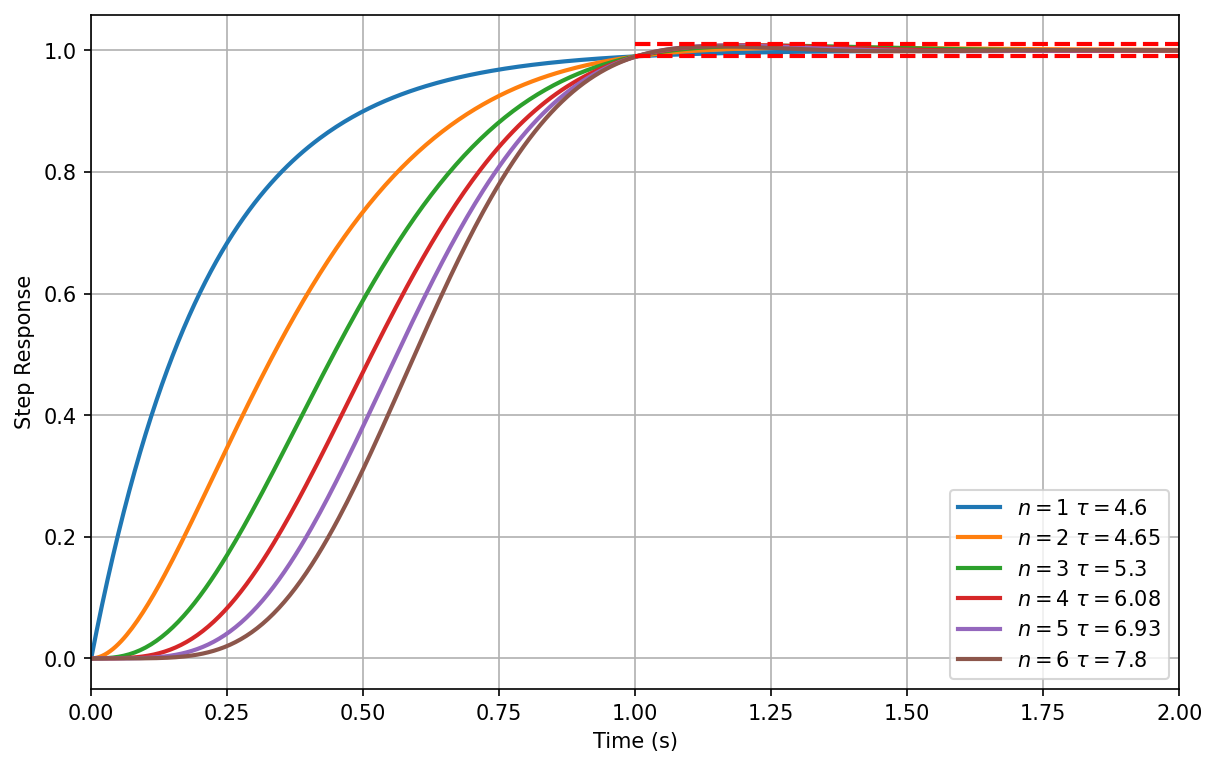

In [ ]:
fig, ax = plt.subplots(1,figsize=(8, 5),dpi=150,constrained_layout = True)
Bessel_poles={}

Npts = 2000
t_Bessel = np.linspace(0, 10, Npts)
ts_targ = 1
Tol = 0.01

def func(tau,t,a,b,Tol=0.01):
    n = len(a) - 1
    AA = [float(xx/tau**(n - kk)) for kk, xx in enumerate(a)]
    y,_ = control.matlab.step(control.matlab.tf(b,AA),T=t)
    # Find the index where y is within 2% of the final value
    index = np.where(np.abs(y - 1) >= Tol)[0][-1]
    return (1.0 - t[index])**2

for n in range(1,7):
    b, a = bessel(n, 1, analog=True)
    sol = minimize(func, x0 = 1,method='Nelder-Mead',args=(t_Bessel,a,b),tol=1e-4)
    tau = sol.x[0]  # Extract the scalar value from the array
    A = [float(xx / tau**(n - kk)) for kk, xx in enumerate(a)]
    y_Bessel,_ = control.matlab.step(control.matlab.tf(b, A), T=t_Bessel)
    plt.plot(t_Bessel, y_Bessel,label=r'$n = $'+str(n)+r' $\tau=$'+str(np.round(tau,2)))
    Bessel_poles[n] = np.roots(A)
    pretty_row_print(np.roots(A),"n = "+str(n)+": ")

plt.legend()
plt.axhline(y=(1+Tol),ls='--',xmin=1/2,c='r')
plt.axhline(y=(1-Tol),ls='--',xmin=1/2,c='r')
plt.xlim(0,2)
plt.ylabel('Step Response')
plt.xlabel('Time (s)')
savefig("figs/Bessel_step_response.pdf", dpi=600)
plt.show()

### <a id='toc1_2_2_'></a>[Example using Bessel Pole Locations](#toc0_)

n = 3
(-3.95 + 3.77i), (-3.95 + -3.77i), -4.990
(-1.98 + 1.89i), (-1.98 + -1.89i), -2.495
[-1.97594702+1.88512156j -1.97594702-1.88512156j -2.49524007+0.j        ]


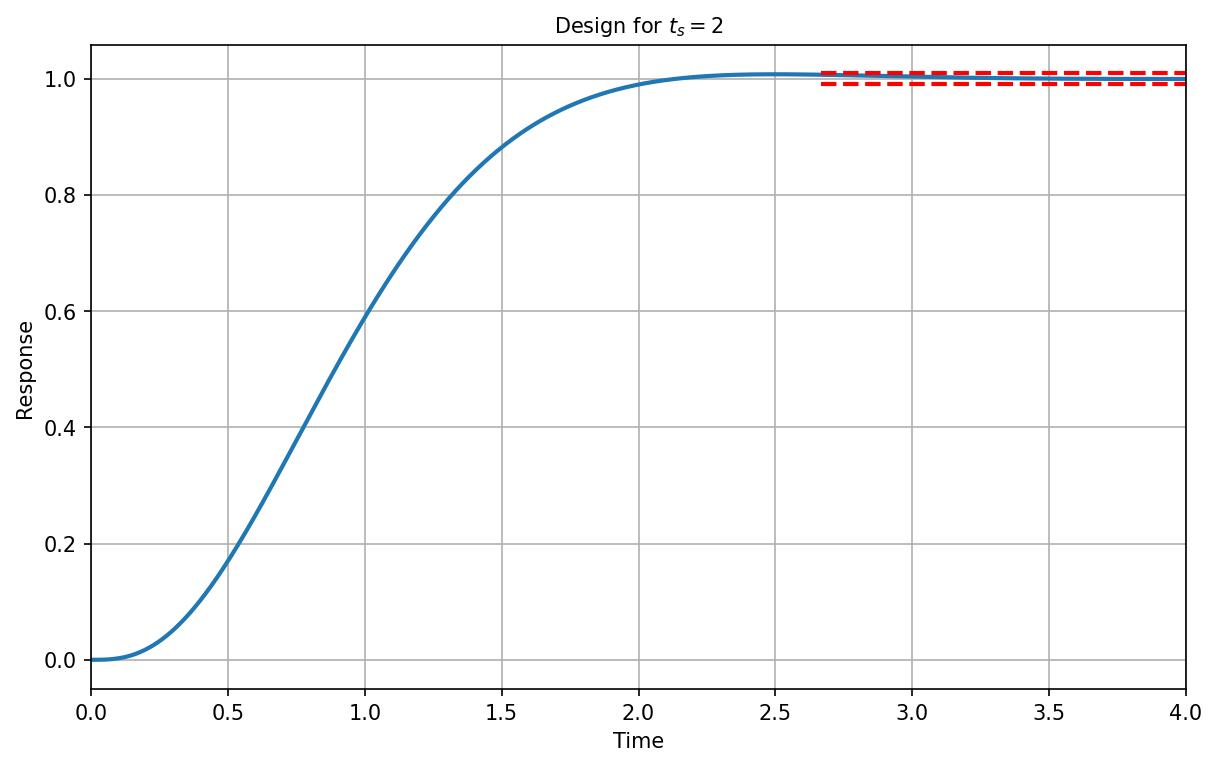

In [ ]:
# system
G = tf(1,[1 ,0]) * tf(1,[1 ,4]) * tf(1,[1 ,1])
n = len(G.den[0][0]) - 1
print(f"{n =: 2d}")
Gss = control.matlab.tf2ss(G)
tau = 2 # scaling factor on time constant
#get p from above cell
if 0:
    p = (complex(-3.95,3.77), complex(-3.95, -3.77), complex(-4.99 , 0.00))
else:
    p = Bessel_poles[n]
pretty_row_print(p)
p_scaled = [pp/tau for pp in p]
pretty_row_print(p_scaled)

K = control.matlab.place(Gss.A,Gss.B,p_scaled)
Acl = Gss.A-Gss.B @ K
print(np.linalg.eig(Acl)[0])
Nbar = compute_Nbar(Gss,K)
Gcl = Nbar*ss(Acl,Gss.B,Gss.C,Gss.D)

t_Bessel = np.linspace(0,2*tau,Npts)
y_Bessel,t_Bessel = control.matlab.step(Gcl,T=t_Bessel)

fig, ax = plt.subplots(1,figsize=(8, 5),dpi=150,constrained_layout = True)
plt.plot(t_Bessel,y_Bessel)
plt.axhline(y=(1+Tol),ls='--',xmin=tau/max(t),c='r')
plt.axhline(y=(1-Tol),ls='--',xmin=tau/max(t),c='r')
plt.ylabel("Response")
plt.xlabel("Time")
plt.title('Design for $t_s=$'+str(tau))
savefig("figs/Bessel_1.pdf", dpi=600)
plt.show()

### <a id='toc1_2_3_'></a>[ITAE Optimize](#toc0_)


 n = 1
-4.602

 n = 2
(-4.96 + 4.33i), (-4.96 + -4.33i)

 n = 3
(-4.46 + 8.82i), (-4.46 + -8.82i), -5.900

 n = 4
(-3.87 + 13.33i), (-3.87 + -13.33i), (-5.87 + 4.26i), (-5.87 + -4.26i)


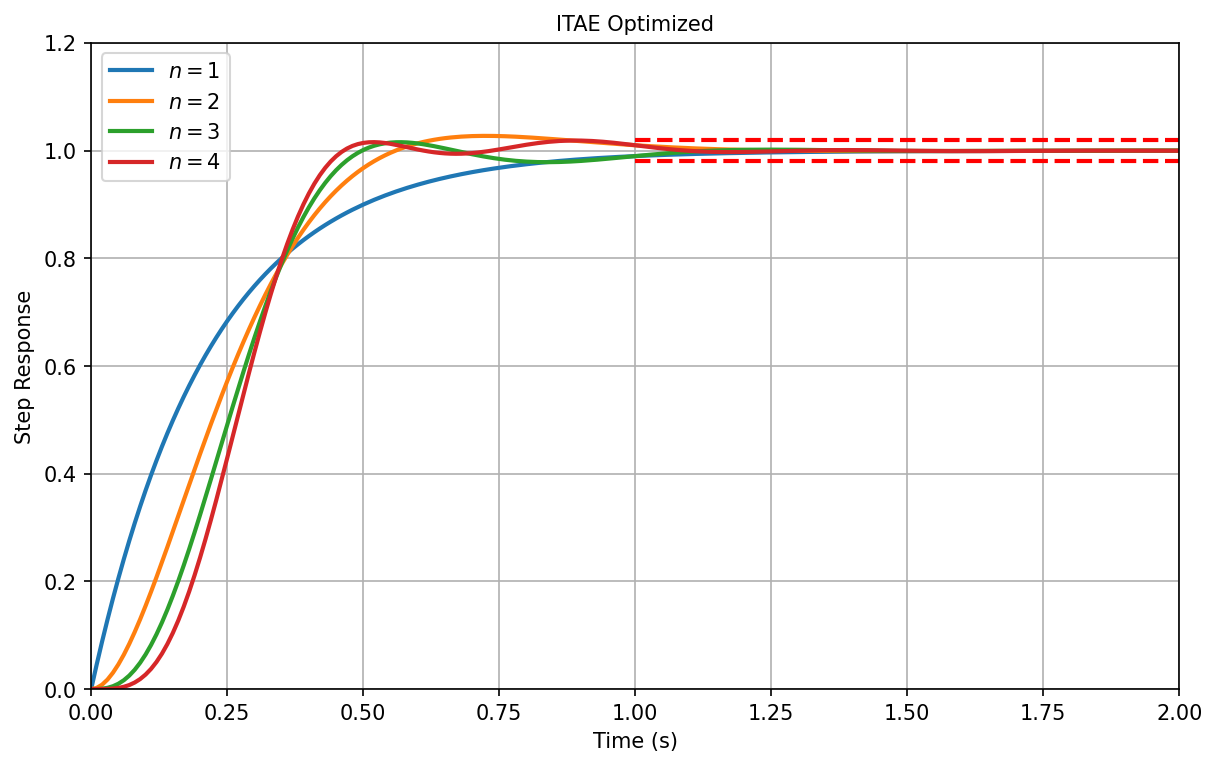

In [ ]:
Npts = 2000
t_ITAE = np.linspace(0, 20, Npts)
ts_targ = 1.0

def func(a,t,b):
    A = [float(a[kk-1]) if kk >= 1 else 1.0 for kk in range(len(a)+1)]
    y,_ = control.matlab.step(control.matlab.tf(b, A), T = t)
    return np.dot((t*np.abs(ts_targ - y))[0:-1],np.diff(t))

fig, ax = plt.subplots(1,figsize=(8, 5),dpi=150,constrained_layout = True)
ITAE_poles = {}
for n in range(1,5):
    b, a = bessel(n, 1, analog=True)
    sol = minimize(func,x0=a[:-1],method='Nelder-Mead',args=(t_ITAE,b))
    #A = [float(sol.x[kk]) if kk < len(sol.x) else 1.0 for kk in range(len(sol.x)+1)]
    A = [float(sol.x[kk-1]) if kk >= 1 else 1.0 for kk in range(len(sol.x)+1)]
    y_ITAE,_ = control.matlab.step(control.matlab.tf(b, A), T=t_ITAE)
    if 0:
        print("\n A")
        pretty_row_print(np.roots(A))
        pretty_row_print(A)
    try:
        index = np.where(np.abs(y_ITAE - 1) >= 0.01)[0][-1]
        tau = t_ITAE[index]
    except:
        tau = 1
    print(f"\n {n = :.0f}")
    AA = [float(xx / tau**(n - kk)) for kk, xx in enumerate(A)]
    y_ITAE,_ = control.matlab.step(control.matlab.tf(1, AA), T=t_ITAE)
    plt.plot(t_ITAE, y_ITAE,label=r'$n = $'+str(n))
    ITAE_poles[n] = np.roots(AA)
    pretty_row_print(np.roots(AA))
    #pretty_row_print(AA)

plt.legend()
plt.axhline(y=1.02,ls='--',xmin=1/2,c='r')
plt.axhline(y=1/1.02,ls='--',xmin=1/2,c='r')
plt.xlim(0,2)
plt.ylim(0,1.2)
plt.ylabel('Step Response')
plt.xlabel('Time (s)')
plt.title("ITAE Optimized")
plt.savefig("figs/ITAE_step_response.pdf", dpi=600)
plt.show()

### <a id='toc1_2_4_'></a>[ITAE step response](#toc0_)

ITAE poles(-4.46 + 8.82i), (-4.46 + -8.82i), -5.900
Scaled poles(-2.23 + 4.41i), (-2.23 + -4.41i), -2.950
Eigenvalues (-2.23 + 4.41i), (-2.23 + -4.41i), -2.950


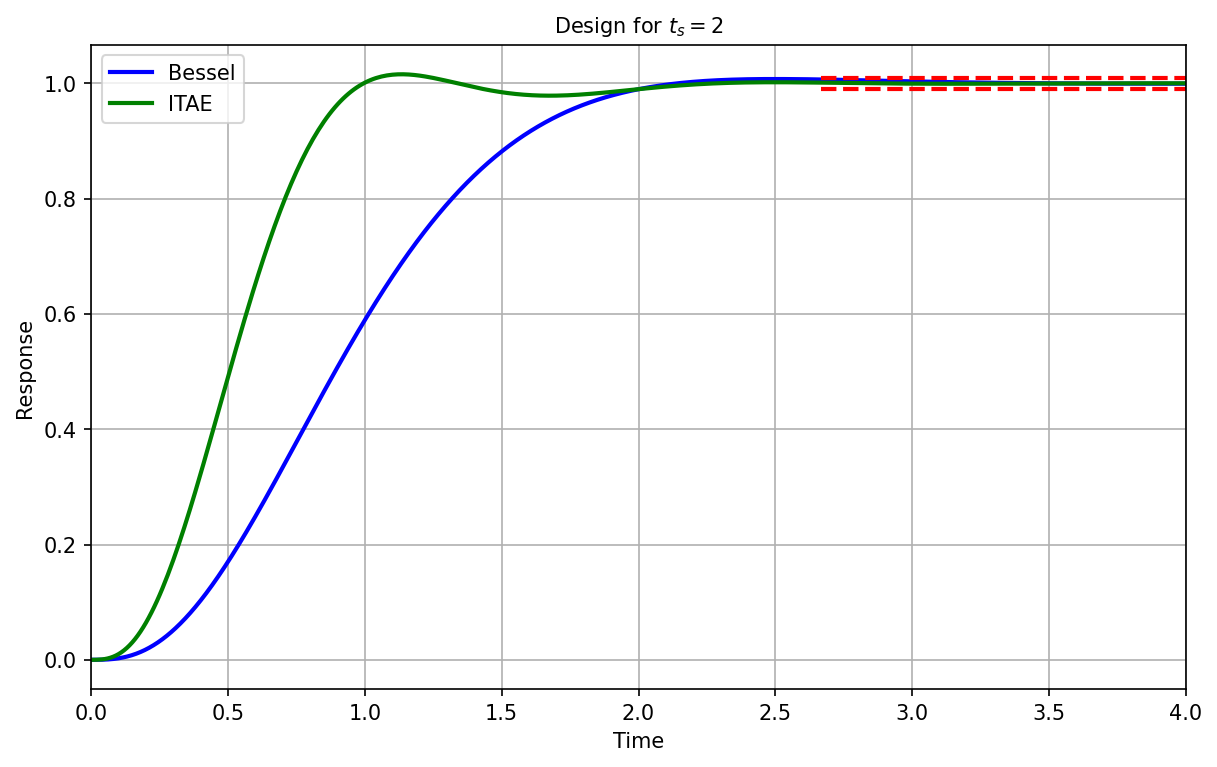

In [ ]:
Tol = 0.01
tau = 2
n = 3
if 0:
    p = (complex(-4.350,8.918),complex(-4.350,-8.918),complex(-5.913))
else:
    p = ITAE_poles[n]
pretty_row_print(p, "ITAE poles")
p_scaled = [pp/tau for pp in p]
pretty_row_print(p_scaled, "Scaled poles")

K = control.matlab.place(Gss.A,Gss.B,p_scaled)
Acl = Gss.A-Gss.B @ K
pretty_row_print(np.linalg.eig(Acl)[0],"Eigenvalues ")
Nbar = compute_Nbar(Gss,K)
Gcl = Nbar*ss(Acl,Gss.B,Gss.C,Gss.D)

y_ITAE,_ = control.matlab.step(Gcl,T=t_ITAE)

fig, ax = plt.subplots(1,figsize=(8, 5),dpi=150,constrained_layout = True)
plt.plot(t_Bessel,y_Bessel,'b',label='Bessel')
plt.plot(t_ITAE,y_ITAE,'g',label='ITAE')
plt.axhline(y=y_ITAE[-1]*(1+Tol),ls='--',xmin=tau/max(t),c='r')
plt.axhline(y=y_ITAE[-1]*(1-Tol),ls='--',xmin=tau/max(t),c='r')
plt.ylabel("Response")
plt.xlabel("Time")
plt.xlim(0,2*tau)
plt.legend()
plt.title('Design for $t_s=$'+str(tau))
savefig("figs/Bessel_2.pdf", dpi=600)
plt.show()
